In [285]:
import numpy as np
import matplotlib.pyplot as plt
from CAMB import camb
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [23]:
wmap = np.loadtxt('Intensity.txt')

In [263]:
#Copied the spectrum function written by Prof. Sievers
def get_spectrum(pars,lmax=2000,fixed_Tau=None):
    if fixed_Tau is None:
        H0=pars[0]
        ombh2=pars[1]
        omch2=pars[2]
        tau=pars[3]
        As=pars[4]
        ns=pars[5]
    else: 
        H0=pars[0]
        ombh2=pars[1]
        omch2=pars[2]
        tau=fixed_Tau
        As=pars[3]
        ns=pars[4]
    pars=camb.CAMBparams()
    pars.set_cosmology(H0=H0,ombh2=ombh2,omch2=omch2,mnu=0.06,omk=0,tau=tau)
    pars.InitPower.set_params(As=As,ns=ns,r=0)
    pars.set_for_lmax(lmax,lens_potential_accuracy=0)
    results=camb.get_results(pars)
    powers=results.get_cmb_power_spectra(pars,CMB_unit='muK')
    cmb=powers['total']
    tt=cmb[:,0]    #you could return the full power spectrum here if you wanted to do say EE
    return tt

In [41]:
opticalDepth = 0.05

In [273]:
def derivative(x,y,p,dx,tau):
    """
    Takes the derivative of the function y (which is the spectrum) in terms 
    of each of its parameters. This is done by varying each parameter by
    a certain dx defined below. 
    """
    grad = np.zeros([len(x),len(p)])
    for i in range(len(p)):
        p_dx = p.copy()
        d_p = p_dx[i]*dx #small change in the parameter in question
        p_dx[i] = p_dx[i] + d_p #Adding that small change to the parameter
        spect_dx = y(p_dx,fixed_Tau=tau)[2:len(x)+2]
        
        p_dx[i] = p_dx[i] - 2*d_p #small change int the other direction
        spect_dx_2 = y(p_dx,fixed_Tau=tau)[2:len(x)+2]
        
        deriv = (spect_dx-spect_dx_2)/(2*d_p)
        grad[:,i] = np.asarray(deriv)
    return grad

def newton_Method(x,y,p,errP,tau):
    chi_sqr = 10000
    l = 0.0001
    g = derivative(x,y,p,0.001,tau)
    p_new = p.copy()
    for j in range(100):
        guessing = y(p_new,fixed_Tau=tau)[2:len(x)+2]
        residual = x - guessing
        chi_sqr_new = (residual**2/errP**2).sum()
        cond = chi_sqr - chi_sqr_new
        if cond<0.001 and cond>0:
            p = p_new.copy()
            g = derivative(x,y,p,0.001,tau)
            N = np.diag(1/errP**2)
            cov = np.dot(g.transpose(),N)
            cov = np.dot(cov,g)
            cov = np.linalg.inv(cov)
            err = np.sqrt(np.diag(cov))
            break
        elif chi_sqr_new > chi_sqr: 
            print ("Chi-squared got bigger, I just increased Lambda!")
            l = 1000*l
            p_new = p.copy()
        else:
            chi_sqr = chi_sqr_new
            p = p_new.copy()
            l = l/700
            g = derivative(x,y,p,0.001,tau)
        residual = np.matrix(residual).transpose()  
        g = np.matrix(g)
        LHS = g.transpose()*np.diag(1/errP**2)*g
        lhs  = LHS +l*np.diag(np.diag(LHS))
        rhs = g.transpose()*np.diag(1/errP**2)*residual
        changeP = np.linalg.inv(lhs)*(rhs)
        for k in range(len(p)):
            p_new[k] = p_new[k] + changeP[k]
        print (f"We are currently in iteration {j}; the chi-squared is {chi_sqr}")
        print (l,'\n')
    return p,cov,err

In [274]:
tau = opticalDepth
pars=np.asarray([65,0.02,0.1,2e-9,0.96])

In [276]:
p, pcov, err = newton_Method(wmap[:,1],get_spectrum,pars,wmap[:,2],tau)

We are currently in iteration 0; the chi-squared is 1588.2376532931526
1.4285714285714287e-07 

We are currently in iteration 1; the chi-squared is 1234.8180386631332
2.0408163265306126e-10 

We are currently in iteration 2; the chi-squared is 1227.9368887029505
2.9154518950437323e-13 

We are currently in iteration 3; the chi-squared is 1227.9356365545236
4.164931278633903e-16 



In [277]:
print (p)
print (err)

[6.93288872e+01 2.24918509e-02 1.13910222e-01 2.04250074e-09
 9.69780030e-01]
[2.40115856e+00 5.39886933e-04 5.22531987e-03 3.90128455e-11
 1.35807412e-02]


# Findings

## Parameters found along with their erros:
The Hubble constant $H_o$ was found to be $69\pm2$.

The Physical Baryon Density was found to be $0.0224\pm0.0005$.

The Cold Dark Matter Density was found to be $0.113\pm0.005$.

The Primordial Power Law was found to be $(2.04\pm0.04)\times 10^{-9}$.

The Slope of the Primordial Law wass found to be $0.97\pm0.01$

## Plotting: 

The fit was plotted with the found parameters along with the raw power spectrum data



In [292]:
fit_mean = get_spectrum(p,fixed_Tau=tau)
fit_min = get_spectrum(p-err,fixed_Tau=tau)
fit_max = get_spectrum(p+err,fixed_Tau=tau)

Text(0.5, 0, 'Multipole Index')

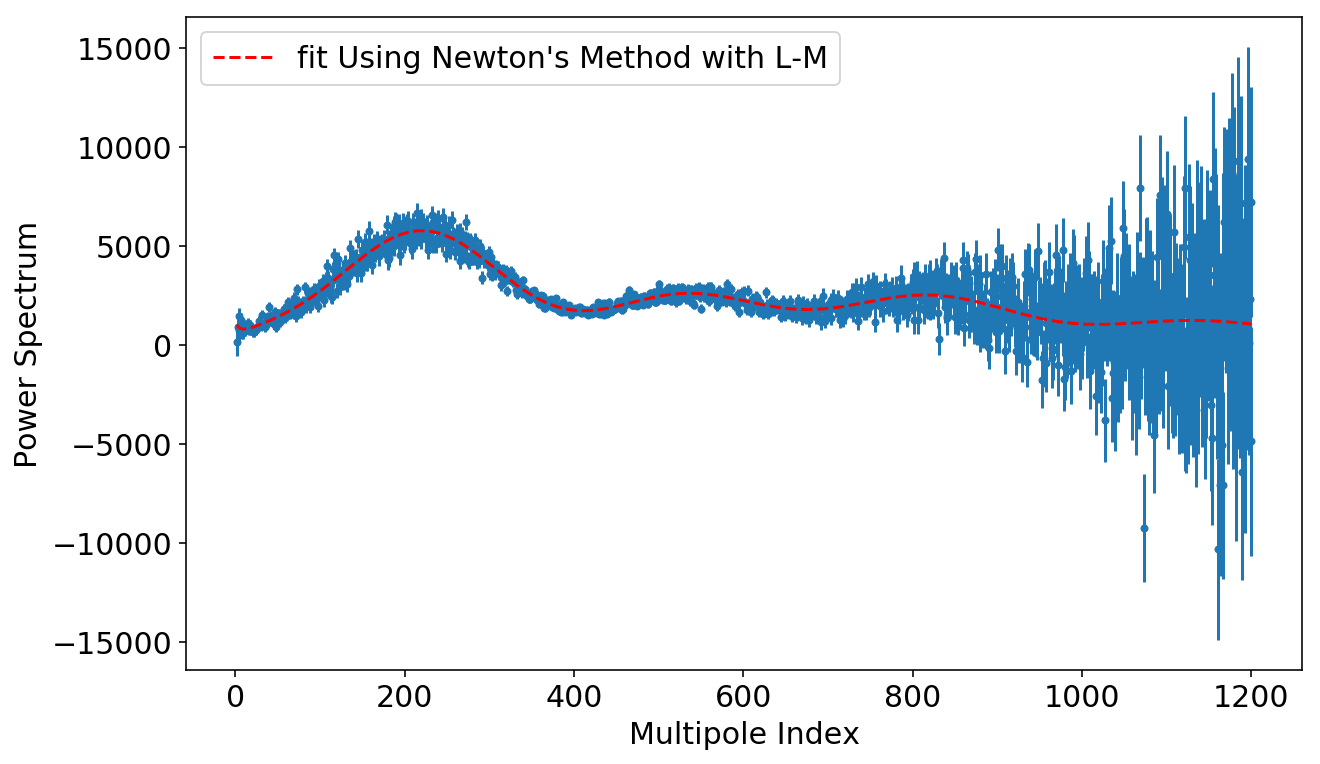

In [308]:
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(wmap[:,0],fit_mean[2:len(wmap[:,0])+2],'--',color='red',label='fit Using Newton\'s Method with L-M')
ax.errorbar(wmap[:,0],wmap[:,1],yerr=wmap[:,2],fmt='.',zorder=1)
plt.legend(fontsize=15,loc='upper left')
ax.tick_params(labelsize=15)
ax.set_ylabel("Power Spectrum",fontsize=15)
ax.set_xlabel("Multipole Index",fontsize=15)

In [173]:
fit_tau = lambda tau: get_spectrum(p,fixed_Tau=tau)
g_1 = derivative(wmap[:,1],fit_tau,np.asarray([tau]),0.001)
print (g_1)
new_tau, new_tau_cov,new_tau_error = newton_Method(wmap[:,1],fit_tau,np.asarray([tau]),g_1,wmap[:,2]) 

5e-05
[[  330.27746387]
 [  183.16195214]
 [  -24.74852215]
 ...
 [-2172.36528338]
 [-2163.84007714]
 [-2155.24773825]]
[ -790.72433595    26.2274555    -89.49509219 ...  1230.75509356
 -5960.41682669  6112.24035553]
[[ 1.09086839e+05  6.04953833e+04 -8.17385871e+03 ... -7.17325991e+05
  -7.14511539e+05 -7.11674921e+05]
 [ 6.04979011e+04  3.35494190e+04 -4.53296721e+03 ... -3.97737360e+05
  -3.96177099e+05 -3.94604547e+05]
 [-8.17024302e+03 -4.53186935e+03  6.12509765e+02 ...  5.39201360e+04
   5.37079175e+04  5.34940328e+04]
 ...
 [-7.17479660e+05 -3.97893548e+05  5.37628507e+04 ...  4.71932823e+06
   4.70080714e+06  4.68214020e+06]
 [-7.14663977e+05 -3.96332054e+05  5.35518645e+04 ...  4.70080837e+06
   4.68235995e+06  4.66376627e+06]
 [-7.11826121e+05 -3.94758265e+05  5.33392168e+04 ...  4.68214267e+06
   4.66376751e+06  4.64524765e+06]]


ValueError: shapes (1199,1199) and (1,1) not aligned: 1199 (dim 1) != 1 (dim 0)